<a href="https://colab.research.google.com/github/justinetaylor/mids-w207-final-project/blob/yang_branch/clear_cut_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Libraries for models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


In [2]:
#mount the drive for file storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/W207-Final-Project')


## Data Engineering

### Load Data

In [4]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Initial Data Exploration

First, we check the data attributes, quality and shape.

In [5]:
# Examine shape 
print(train_df.shape)

# Briefly examine feature attributes for the training data 
train_df.describe()

(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [6]:
train_df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [7]:
# Collect numeric feature column names - so we can easily access these columns when modifying them 
num_cols = ['Elevation', 'Slope','Aspect',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

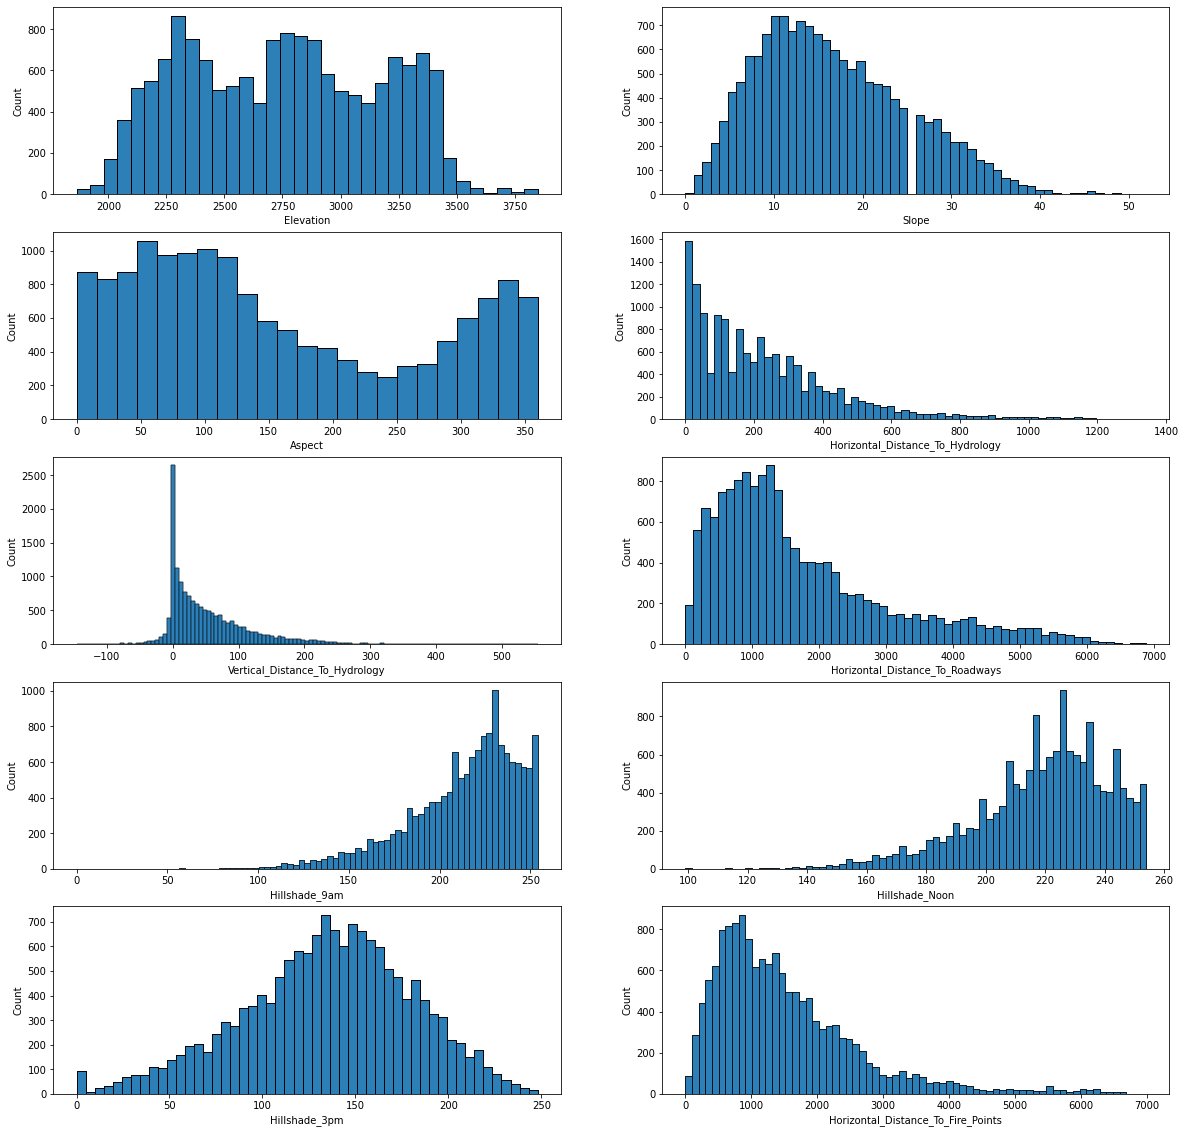

In [8]:
#visualize the distribution of numerical columns
col_ct = len(num_cols)
rows = col_ct//2
fig, axes = plt.subplots(rows,2,figsize=(20,20))
for i in range(col_ct):
  for j in range(2):
    col= train_df[num_cols[j+2*(i//2)]]
    sns.histplot(col, ax=axes[i//2][j])
    axes[i//2][j].grid()

Here we can see the distribution are skewed for a few variables, such as "Horizontal_Diestance_To_Fire_points". A log-transformation may imporve the model performance. Also, a "min max" scaler may work better for variables that is clearly not normally distributed, such as "Vertical_Distance to_Hydrology".

Here we can see that the training data has a somewhat uniform distribution of covertype and this tells us that our data set is balanced. 

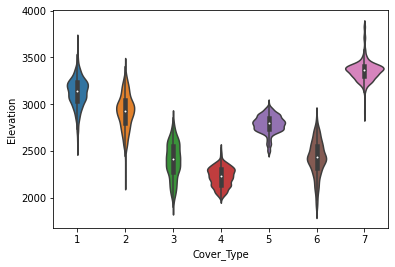

In [9]:
sns.violinplot(x=train_df['Cover_Type'],y=train_df['Elevation'])
plt.show()

Here, we can see there is a relationship between the cover type and elevation. 

In [10]:
# get NA values

print("There are {} NA values in the training data".format(train_df.isna().sum().sum()))
print("There are {} NA values in the test data".format(train_df.isna().sum().sum()))
    # `.isna()` returns a df with bools the first `.sum()` returns series, second is int 
print()
print("There are {} values in the training data".format(train_df.count()[0]))
print("There are {} values in the test data".format(test_df.count()[0]))

There are 0 NA values in the training data
There are 0 NA values in the test data

There are 15120 values in the training data
There are 565892 values in the test data


No null values in the dataset. Also noted the "aspect" variable has a value between 0 and 359. This is expressed in degrees, compared to "true north". Will conver this ino sine(EW) and cosine(NS) values. 

Now, we'll isolate and explore the distribution of soil types. 

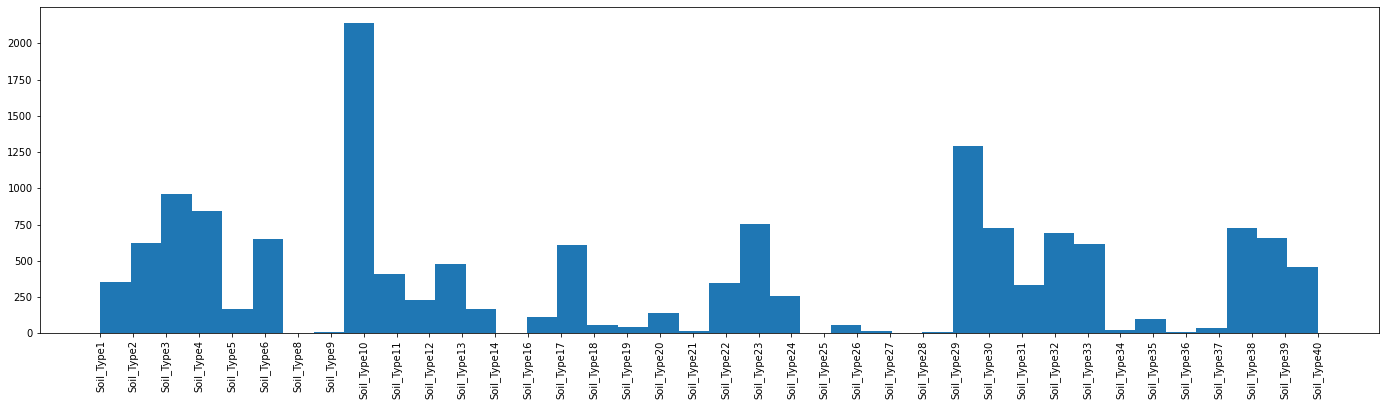

In [12]:
# Isolate soil type column names
soil_df = train_df[["Cover_Type",'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']]

# Now we convert the soil type columns back into one column with values as the "soil type"
soil_df_unpivoted = soil_df.melt(id_vars="Cover_Type",var_name="soil_type",value_name="yes")
mask1 = soil_df_unpivoted["yes"] ==1 #only keep rows of where the "soil type" is "yes"
soil_df_unpivoted = soil_df_unpivoted[mask1]

# Histogram of soil types by "cover type"
plt.figure(figsize=(24,6))
plt.hist(soil_df_unpivoted["soil_type"],bins=40)
plt.xticks(rotation=90)
plt.show()

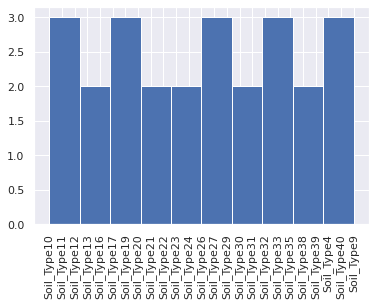

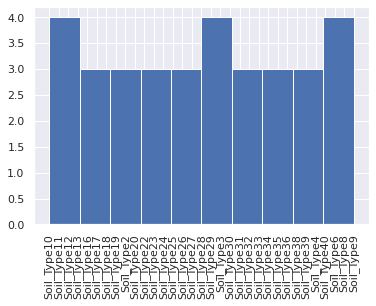

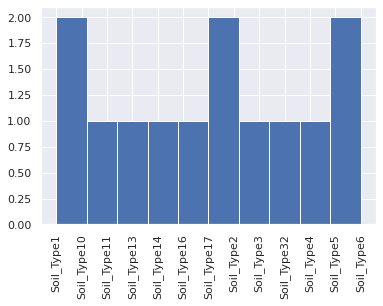

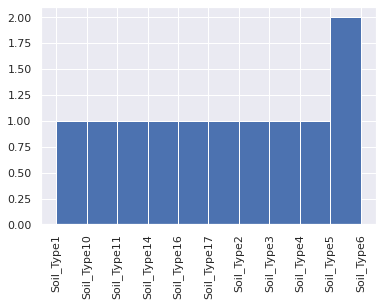

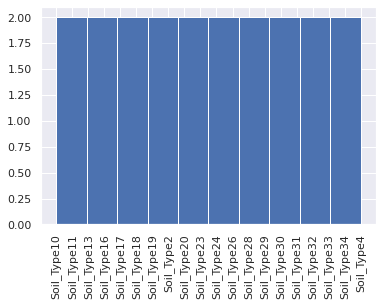

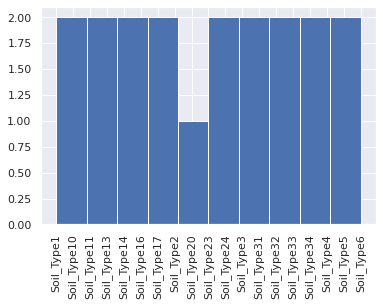

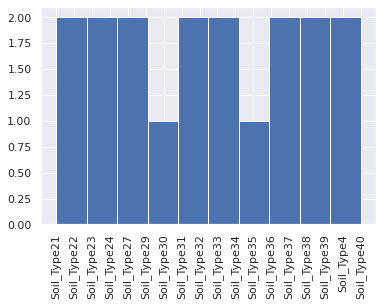

In [26]:
df1 = soil_df_unpivoted.groupby(["Cover_Type","soil_type"], as_index=False).count()
for i in range(1,8):
  plt.hist(df1[df1["Cover_Type"] == i]["soil_type"])
  plt.xticks(rotation=90)
  plt.show()

As we can see in the histogram above, there is an uneven distribution of occurances of soil types.

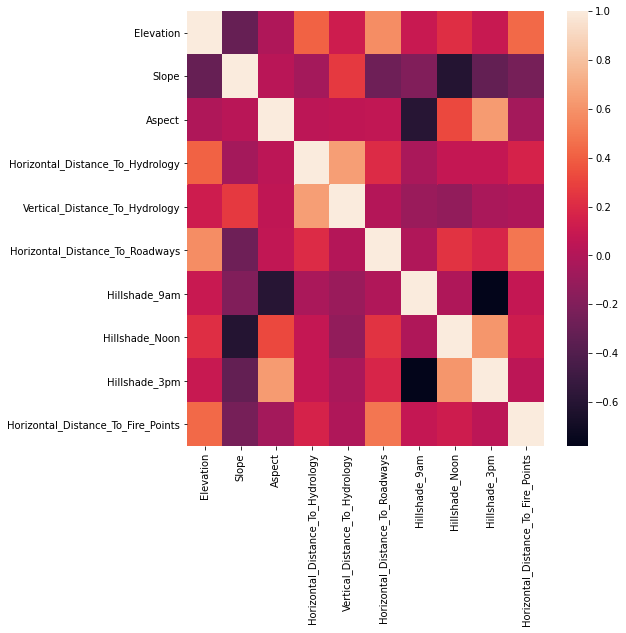

In [12]:
# Explore correlations between numerical features
train_corr=train_df[num_cols].corr()

#plot a heat map for correlations
ax = plt.figure(figsize=(8,8))
sns.heatmap(train_corr, xticklabels=train_corr.columns.values, yticklabels=train_corr.columns.values)

In [42]:
# Rank correlations with "cover type"
train_corr1=train_df.corr()
train_corr1['Cover_Type'].abs().sort_values(ascending=False)[:31]

Cover_Type                            1.000000
soil_type35383940                     0.444575
Wilderness_Area1                      0.230117
Soil_Type29                           0.218564
Soil_Type22                           0.195993
Soil_Type23                           0.158762
Soil_Type32                           0.132312
Soil_Type12                           0.129985
Soil_Type10                           0.128972
Wilderness_Area3                      0.122146
Horizontal_Distance_To_Roadways       0.105662
Soil_Type24                           0.100797
Hillshade_Noon                        0.097766
Horizontal_Distance_To_Fire_Points    0.089389
Slope                                 0.087722
Soil_Type31                           0.079882
Soil_Type33                           0.078955
Wilderness_Area4                      0.075774
Vertical_Distance_To_Hydrology        0.075647
Soil_Type37                           0.071210
Hillshade_3pm                         0.053399
Soil_Type20  

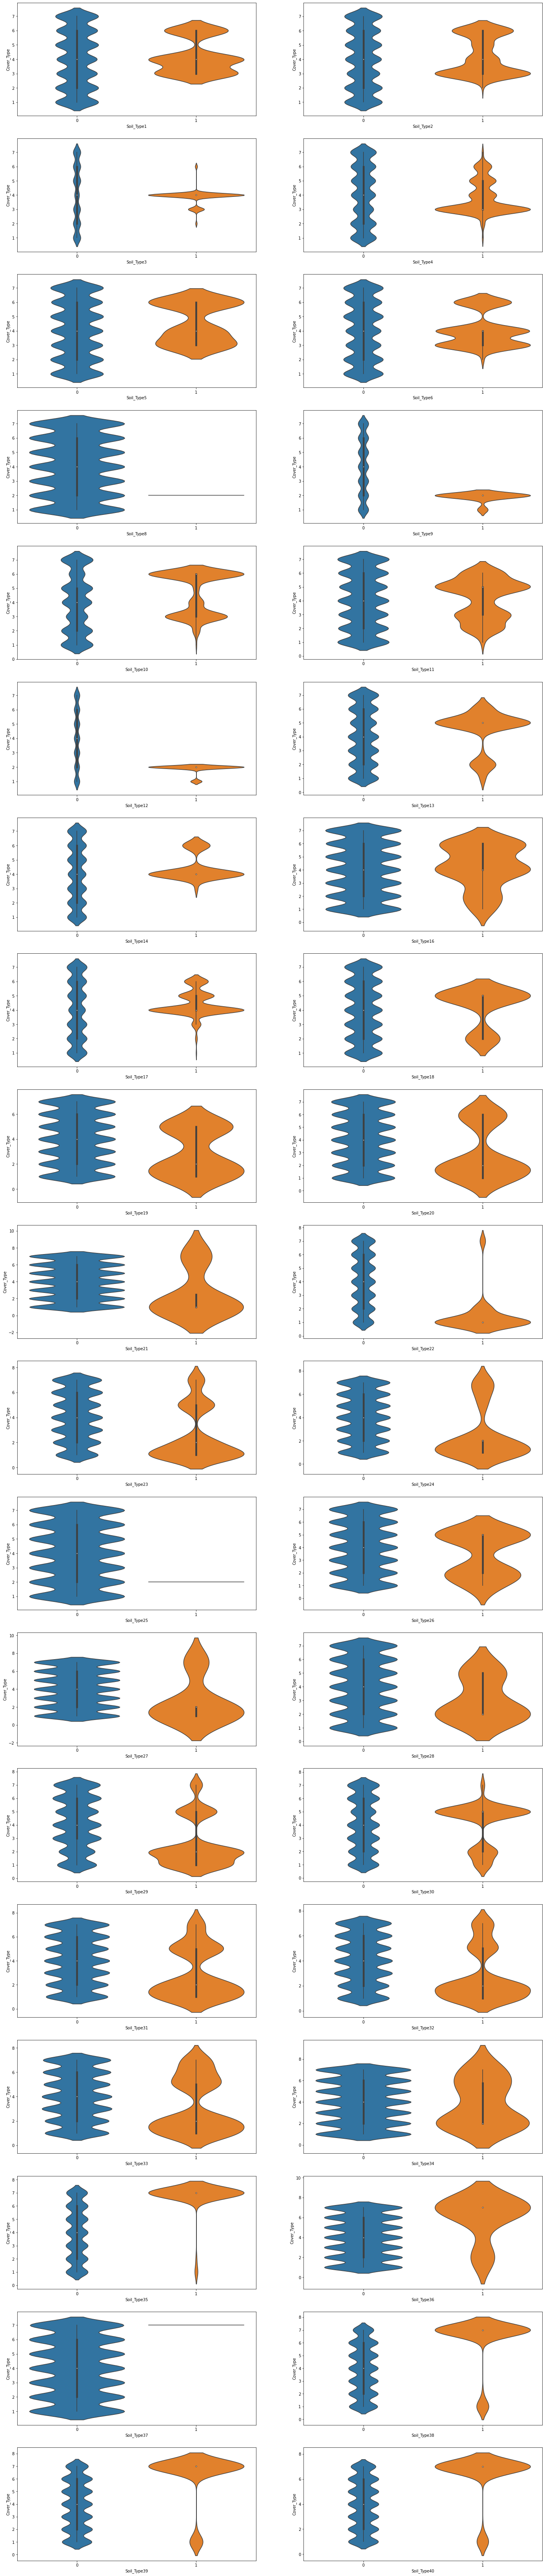

In [15]:
# Visualize the distribution of soil type and "cover type"
st_list = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16','Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

fig, axes = plt.subplots(19,2,figsize=(24,120))
for i in range(len(st_list)):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[st_list[i]], ax=axes[i//2,i%2])
plt.show()

Here we can examine the relationship between soil type and cover type for each soil type. # TODO: Discuss more

Now, we'll isolate and explore the distribution of wilderness types. 

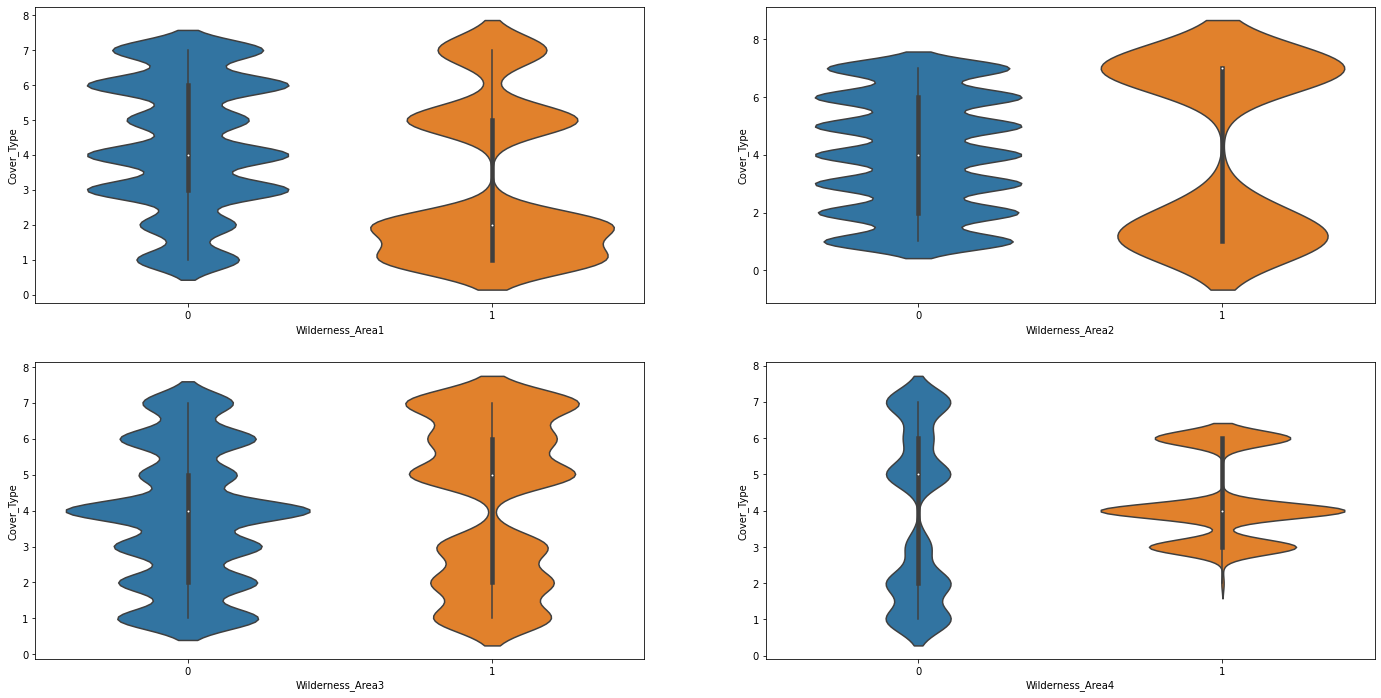

In [16]:
wilderness_list =['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

# Visualize the distribution of wilderness area and "cover type"
fig, axes = plt.subplots(2,2,figsize=(24,12))
for i in range(4):
    sns.violinplot(y=train_df['Cover_Type'],x=train_df[wilderness_list[i]], ax=axes[i//2,i%2])
plt.show()

link text### Feature Engineering 1

Now we'll log transform a few variables.

In [17]:
#put log transofmration candidates in one list.
log_cols = ['Hillshade_Noon']

In [18]:
train_df[log_cols] = np.log(train_df[log_cols])

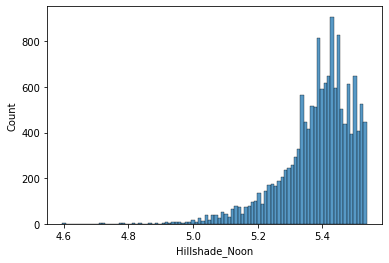

In [19]:
#visualize the frequency plot after log transformation.
sns.histplot(train_df["Hillshade_Noon"])
plt.show()

[link text](https://)### Feature Engineering 2

Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

In [20]:
# Remove soil type 7 and 15 due to no data
train_df.drop(columns=["Soil_Type7", "Soil_Type15"], inplace=True)

# Remove soil type 19, 37, 34, 21, 27,36,9, 28,8,25 due to no limited data - TODO: should we be dropping these? 
# train_df.drop(columns=["Soil_Type19", "Soil_Type37","Soil_Type34", "Soil_Type21","Soil_Type27", "Soil_Type36","Soil_Type9", "Soil_Type28","Soil_Type8", "Soil_Type25"], inplace=True)

# Combine soil type 35,38,39, 40
train_df["soil_type35383940"] = train_df["Soil_Type38"] +  train_df["Soil_Type39"] + train_df["Soil_Type40"] +  train_df["Soil_Type35"]
train_df.drop(columns=["Soil_Type35","Soil_Type38", "Soil_Type39",'Soil_Type40'], inplace=True)

def combine_st(l):
  new_col = "soil_type"+''.join([str(num) for num in l])


# Check shape is as expected
print(train_df.shape)


(15120, 51)


In [21]:
#drop Id column as it is not a meaningful feature.
train_df.drop(columns=["Id"],inplace=True)
test_df.drop(columns=["Id"],inplace=True)

In [22]:
# get NA values

print("There are {} NA values in the training data".format(train_df.isna().sum().sum()))
print("There are {} NA values in the test data".format(train_df.isna().sum().sum()))
    # `.isna()` returns a df with bools the first `.sum()` returns series, second is int 
print()
print("There are {} values in the training data".format(train_df.count()[0]))
print("There are {} values in the test data".format(test_df.count()[0]))

There are 0 NA values in the training data
There are 0 NA values in the test data

There are 15120 values in the training data
There are 565892 values in the test data


### Additional Data Mungling

Then, we split the training data into a training data set (80%) and development data set (20%). We will also have a large, separate test data set. 

In [23]:
# Split training data (labeled) into 80% training and 20% dev) and randomly sample 
training_data = train_df.sample(frac=0.8)
dev_data_df = train_df.drop(training_data.index)

# Examine shape of both data sets
print(training_data.shape)
print(dev_data_df.shape)

# Briefly examine feature attributes for the training data 
training_data.describe()

(12096, 50)
(3024, 50)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type36,Soil_Type37,Cover_Type,soil_type35383940
count,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000,12096.000000
mean,2750.934772,156.784970,16.460565,228.096726,51.549107,1721.603836,212.692874,5.383796,135.304812,1507.145585,0.238839,0.033565,0.420883,0.306713,0.022404,0.040261,0.062583,0.055886,0.011078,0.042411,0.000083,0.000661,0.141617,0.027116,0.015129,0.032738,0.011491,0.008102,0.040013,0.003555,0.003059,0.009094,0.000992,0.022239,0.050761,0.017113,0.000083,0.003555,0.001157,0.000413,0.085317,0.049769,0.022487,0.046131,0.039517,0.001323,0.000744,0.002397,3.989666,0.128720
std,417.651413,109.971134,8.453189,209.988644,61.586575,1329.957227,30.471665,0.111605,45.851713,1094.877225,0.426392,0.180114,0.493721,0.461148,0.148000,0.196579,0.242221,0.229711,0.104672,0.201533,0.009092,0.025710,0.348671,0.162429,0.122071,0.177958,0.106585,0.089649,0.195998,0.059519,0.055225,0.094931,0.031483,0.147465,0.219517,0.129698,0.009092,0.059519,0.034002,0.020328,0.279365,0.217475,0.148266,0.209777,0.194830,0.036347,0.027268,0.048907,2.002473,0.334904
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,59.000000,4.595120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,765.000000,196.000000,5.332719,107.000000,731.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,2755.000000,126.000000,15.000000,180.000000,33.000000,1318.000000,220.000000,5.407172,138.000000,1252.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
75%,3106.250000,260.000000,22.000000,330.000000,80.000000,2283.250000,235.000000,5.463832,167.000000,1988.250000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

Additionally, we will scale the training data to have a mean of 0 and a variance of 1. Then we will retrieve the original training mean and variance for each feature and use that to standardize the development data.

In [24]:
# Split into data and labels
train_data = training_data.drop(columns=["Cover_Type"])
train_labels = training_data["Cover_Type"]
dev_data = dev_data_df.drop(columns=["Cover_Type"])
dev_labels = dev_data_df["Cover_Type"]
test_data = test_df

# Double check the shape
print(train_data.shape)
print(dev_data.shape)

(12096, 49)
(3024, 49)


In [25]:
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37',
       'soil_type35383940'],
      dtype='object')

In [26]:
#compile a list for columns for standard scaling
minmax_cols = ["Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Hydrology",'Horizontal_Distance_To_Roadways', 'Hillshade_9am']
ss_cols = list(set(num_cols)-set(minmax_cols))

In [27]:
# Normalize features using the standard scaler [training data]
std_scaler = StandardScaler()
norm = std_scaler.fit(train_data[ss_cols])
train_data[ss_cols] = norm.transform(train_data[ss_cols])
print(train_data.shape)
# Normalize features using the standard scaler [dev data]
dev_data[ss_cols] = norm.transform(dev_data[ss_cols])


mm_scaler = MinMaxScaler()
mm = mm_scaler.fit(train_data[minmax_cols])
train_data[minmax_cols] = mm.transform(train_data[minmax_cols])
print(train_data.shape)
# Normalize features using the standard scaler [dev data]
dev_data[minmax_cols] = mm.transform(dev_data[minmax_cols])
print(dev_data.shape)


(12096, 49)
(12096, 49)
(3024, 49)


In [28]:
# Double check shape
print(train_data.shape, dev_data.shape)

(12096, 49) (3024, 49)


In [29]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
print("Test data shape: ", test_data.shape)

Training data shape: (12096, 49) Training labels shape: (12096,)
Dev data shape: (3024, 49) Dev labels shape: (3024, 49)
Test data shape:  (565892, 54)


In [30]:
# Examine Training Data 
dev_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type36,Soil_Type37,soil_type35383940
0,-0.370982,-0.961974,-1.592431,0.192107,0.208571,0.074020,0.830769,0.563989,0.276886,4.358527,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0.081567,-0.016232,0.182120,0.180194,0.377143,0.448476,0.917949,0.792780,-0.290182,4.296417,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,-0.332671,-0.889224,-0.764307,0.183917,0.224286,0.092308,0.866667,0.047276,-0.246562,4.313771,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
12,-0.021394,-0.207199,0.655334,0.111690,0.307143,0.466618,0.969231,0.249553,-0.944493,4.186811,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14,-0.593665,0.001955,-1.474128,0.049888,0.214286,0.097823,0.846154,0.867764,0.342317,3.738340,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
all_features = set(train_data.columns.to_list())

In [32]:
#select features 
to_drop = set(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'])


In [33]:
sel_features = list(all_features - to_drop)

In [34]:
dev_data = dev_data[sel_features]
train_data =train_data[sel_features]


In [35]:
# Explore and confirm the shape of the data
print("Training data shape: {0} Training labels shape: {1}".format(train_data.shape, train_labels.shape))
print("Dev data shape: {0} Dev labels shape: {1}".format(dev_data.shape, dev_data.shape))
# print("Test data shape: ", test_data.shape)

Training data shape: (12096, 46) Training labels shape: (12096,)
Dev data shape: (3024, 46) Dev labels shape: (3024, 46)


In [36]:
# get NA values
train_data.head(20)

,Wilderness_Area4,Soil_Type10,Soil_Type4,Soil_Type11,Soil_Type19,Soil_Type6,Soil_Type28,Soil_Type22,Soil_Type36,Soil_Type27,Soil_Type37,Wilderness_Area3,Soil_Type17,Soil_Type18,Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology,Soil_Type30,Soil_Type32,Soil_Type33,Horizontal_Distance_To_Fire_Points,Soil_Type23,Soil_Type2,Horizontal_Distance_To_Hydrology,Slope,Soil_Type16,Soil_Type25,Soil_Type1,Soil_Type29,soil_type35383940,Soil_Type31,Wilderness_Area2,Soil_Type3,Soil_Type5,Wilderness_Area1,Soil_Type24,Soil_Type20,Soil_Type12,Elevation,Soil_Type34,Soil_Type26,Soil_Type8,Soil_Type9,Soil_Type14,Soil_Type13,Aspect,Soil_Type21
11126,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.059216,0.254286,0,0,0,-0.795689,0,0,0.044676,1.601762,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.904942,0,0,0,0,0,0,1.484224,0
7861,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.278229,0.208571,0,0,0,0.441944,0,0,0.000000,-0.054486,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.421265,0,0,0,0,0,0,-0.270855,0
733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.638171,0.217143,0,0,0,0.983580,0,0,0.049888,0.063817,0,0,0,1,0,0,0,0,0,1,0,0,0,0.653838,0,0,0,0,0,0,-0.916505,0
2394,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.219594,0.212857,0,0,0,-0.392887,1,0,0.022338,-0.882611,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.109988,0,0,0,0,0,0,1.056821,0
7486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.246299,0.311429,0,0,0,0.185284,0,0,0.446761,0.418727,0,0,0,0,1,0,0,0,0,1,0,0,0,1.436820,0,0,0,0,0,0,-0.707351,0
14672,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.338752,0.321429,0,0,0,-0.538115,0,0,0.201042,1.838369,0,0,0,0,1,0,0,0,0,0,0,0,0,1.549359,0,0,0,0,0,0,-0.443634,0
11336,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.047896,0.310000,0,0,0,-0.469611,0,0,0.290395,1.720065,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.651132,0,0,0,0,0,0,0.611231,0
1856,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.091582,0.227143,0,0,0,-0.170935,0,0,0.063291,-0.646004,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.787615,0,0,0,0,0,0,-1.016536,0
5002,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.029173,0.260000,0,0,0,-1.289829,0,0,0.063291,1.483458,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.974381,0,0,0,0,0,0,1.593348,0
7708,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.495356,0.510000,0,0,0,0.236433,0,0,0.479523,0.300424,0,0,0,0,1,0,0,0,0,0,0,0,0,1.518231,0,0,0,0,0,0,-1.052910,0


## Models
#### Random Forest

Random Forest Performance for 1 trees: 0.6213624338624338
Random Forest Performance for 3 trees: 0.6904761904761905
Random Forest Performance for 5 trees: 0.7116402116402116
Random Forest Performance for 10 trees: 0.7371031746031746
Random Forest Performance for 100 trees: 0.7665343915343915


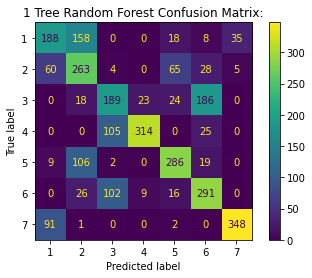

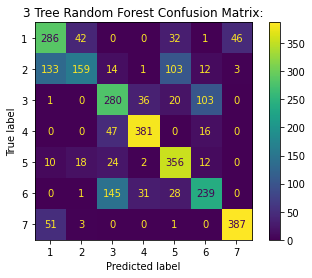

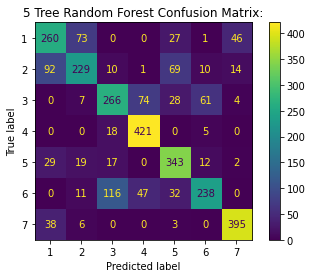

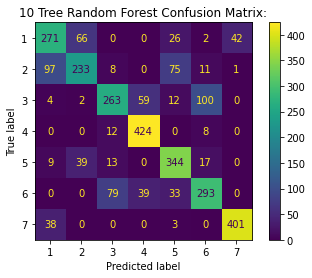

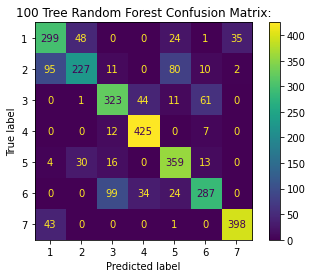

In [37]:
# Try a random forest - before any data cleaning 
def RandomForest(num_trees):
    model = RandomForestClassifier(num_trees,max_depth=8)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Random Forest Performance for {0} trees: {1}".format(num_trees,score))
    # Plot_confusion_matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("{} Tree Random Forest Confusion Matrix:".format(num_trees))
    plt.plot()
    
num_trees_list = [1,3,5,10,100]
for num_trees in num_trees_list:
    RandomForest(num_trees)

#### Naive Bayes (Bernoulli)

BernoulliNB for alph = 0.01: accuracy = 0.5882936507936508





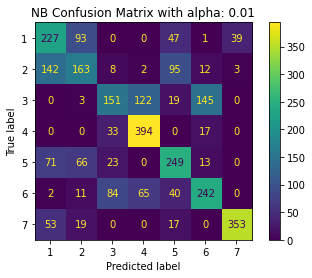

In [38]:
# Try Naive Bayes - Bernoulli 
def NB(alf):
    model = BernoulliNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("BernoulliNB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [0.01]
for alpha in alphas_list:
    NB(alpha)

In [39]:
# Try Naive Bayes - multi-nominal
def MNB(alf):
    model = MultinomialNB(alpha = alf)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("Multi NB for alph = {0}: accuracy = {1}".format(alf,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("Multi NB Confusion Matrix with alpha: {}".format(alf))
    plt.plot()
    print('\n\n')
    
# the alpha isn't actually making a difference 
# alphas_list = [0.00001,0.001, 0.01, 0.1, 1, 10]
alphas_list = [1.0]
for alpha in alphas_list:
    MNB(alpha)

ValueError: ignored

#### K-Nearest Neighbors

KNN 1 neighbors : accuracy = 0.7943121693121693
KNN 2 neighbors : accuracy = 0.7648809523809523
KNN 4 neighbors : accuracy = 0.7741402116402116
KNN 7 neighbors : accuracy = 0.7645502645502645
KNN 10 neighbors : accuracy = 0.7559523809523809


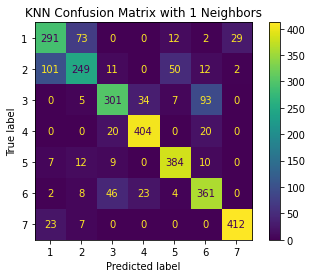

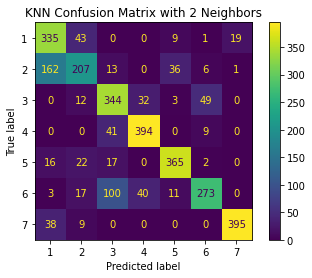

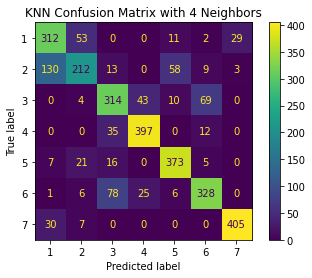

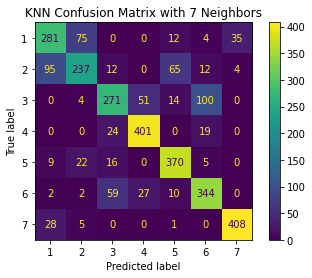

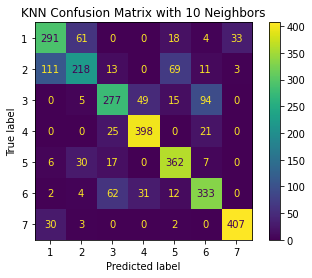

In [40]:
# Try K Nearest Neighbors - before any data cleaning 
def KNN(kn):
    model = KNeighborsClassifier(n_neighbors = kn)
    model.fit(train_data, train_labels)
    predictions = model.predict(dev_data)
    score = model.score(dev_data, dev_labels)
    print("KNN {0} neighbors : accuracy = {1}".format(kn,score))
    # Plot Confusion Matrix
    plot_confusion_matrix(model, dev_data, dev_labels, values_format = "d")
    plt.title("KNN Confusion Matrix with {} Neighbors".format(kn))
    plt.plot()
    
# The alpha isn't actually making a difference 
neigh_list = [1,2,4, 7, 10]
for neigh in neigh_list:
    KNN(neigh)

#### Multi-layer Perceptron

In [41]:
# Try Multi-Layer Perceptron - before any data cleaning 
def MLP():
#    model = MLPClassifier(solver='adam', alpha=1e-6, hidden_layer_sizes=(100, ), random_state=0) .8257
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0)  .82969
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200, ), random_state=0) .837
#    model = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(100, ), random_state=0, activation='tanh') .83068

    # Default activation is 'relu', random state lets us get the same result every time (so we can tune other parameters)
    # max_iter is 200 by default, but more helps. alpha is the regularization parameter. solver is 'adam' by default
    model = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(100,), random_state=0, max_iter=300) 
    model.fit(train_data, train_labels) 
    score = model.score(dev_data, dev_labels)
    print("MLP accuracy = ",score)

    
MLP()

MLP accuracy =  0.8029100529100529


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#logistic regression
def LR():
  model = LogisticRegression(random_state=0, multi_class='ovr',solver='lbfgs', max_iter = 300)
  model.fit(train_data, train_labels)
  score = model.score(dev_data,dev_labels)
  print("Logistic Regression accuracy = ",score)
LR()

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * the url for it
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [ ]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear-cut-solution.ipynb --to="python" --output="backups/clear-cut-solution"
!jupyter nbconvert clear-cut-solution.ipynb --to markdown --output="backups/clear-cut-solution"

# Also archiving this bad boy
!jupyter nbconvert clear-cut-solution.ipynb --to html --output="backups/clear-cut-solution"